## Atividade 04
Com base no código de treinamento de rede neural apresentado durante a aula, modifique o código para que a rede seja treinada utilizando batches e não mais utilizando todo o conjunto de dados. Algumas observações:

1. O batch é criado somente no treinamento.
2. O teste é executado somente uma vez por época.

Compare o aprendizado entre o treinamento utilizando batch e o treinamento utilizando o dataset inteiro. A métrica pode ser quantas épocas são necessárias para ter acurácia 100% no teste.

**Test with Iris dataset and Test and train split function**

In [50]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
#loading dataset
iris = load_iris()
X, y = iris.data, iris.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(120, 4)
(120,)
(30, 4)
(30,)


### Architecture definition

In [51]:
import torch.nn as nn

class ANN(nn.Module) :
    def __init__(self, num_classes=3):
        super(self.__class__, self).__init__()

        self.fullyConnected = nn.Sequential(
            nn.Linear(in_features=4, out_features=10), #out_features are the same in_features in next nn.Linear
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=num_classes),
        )
    
    def forward(self, x, debug=False):
        if debug : print('input',x.shape)
        y = self.fullyConnected(x)
        if debug : print('output',y.shape)
        return y

### Model analysis

In [52]:
import torch

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
    print("Running on CUDA.")
else:
    my_device = torch.device("cpu")
    print("No Cuda Available")

net = ANN( num_classes=3 )

net = net.to(my_device)

a = torch.rand( (1, 4) )
a = a.to(my_device)
b = net( a , debug=True )

del a, b, net

Running on CUDA.
input torch.Size([1, 4])
output torch.Size([1, 3])


In [53]:
from torchsummary import summary

net = ANN( num_classes=3 )

net = net.to(my_device)
#calcular quantidade de parametros
summary(net, input_size=(120, 4), batch_size=1)

del net

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       50
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       220
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       63
Total params: 333
Trainable params: 333
Non-trainable params: 0


### Training functions -  Batch based learning steps

In [54]:
from sklearn.model_selection import train_test_split
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset

import numpy as np

def train_batch ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0, batch_size=32 ) :
    
    num_classes = 3
    
    tensorboard_path = 'logs/' # Setar o caminho para salvar o log para o TensorBoard
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  
    smallest_loss = float('inf')
    
    # Present the data to the model
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).float()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).float()
    test_label = test_label.to(device)
    
    #Split the data into batches
    #train_set = TensorDataset(train_x, train_label)
    #train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    num_batches =  int(np.ceil(len(train_x) / batch_size))
    train_loader = []
    for i in range(0, num_batches):
        batch_x = train_x[(i * batch_size): ((i+1) * batch_size)]
        batch_label = train_label[(i * batch_size): ((i+1) * batch_size)]
        train_loader.append((batch_x, batch_label))
        


    writer.add_graph(net, train_x)
    
    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        net.train()
        epoch_loss = 0
        
        #For each batch of the data
        for batch_x, batch_label in train_loader:
            optimizer.zero_grad() #reset gradients of all the parameters to zero before computing the gradients
            #for the next batch
            
            #For each sample of the batch, calculate the loss
            predict_y = net(batch_x.to(device))
            error = criterion(predict_y, batch_label.to(device).long())
            
            # Back propagation
            error.backward()
            optimizer.step()

            epoch_loss += error.item()
        #calculate the full loss
        full_loss = epoch_loss / len(train_loader)
        
        accuracy_test = validate(net, test_x, test_label, device=device)
        accuracies.append(accuracy_test)
        
        writer.add_scalar( 'Loss/train', full_loss, epoch )
        writer.add_scalar( 'Accuracy/train', accuracy_test, epoch )
        writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )
        if layers2tensorboard :
           plot_layers( net, writer, epoch ) 

        #Test Model
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracies[-1]
            print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                    f'with Accuracy: {max_accuracy:8.4f}%')
            
      
        if debug : print( f'Epoch: {epoch+1:3d} |' 
                         + f'Accuracy Test: {accuracy_test:3.4f}%' )

        if accuracy_test > upper_bound :
            break
    
    if save : 
        models_path = '' # Setar o caminho para salvar o modelo final
        path = f'{models_path}ANN-iris-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(accuracies)

    writer.flush()
    writer.close()

    return best_model


### Training functions 

In [55]:
from sklearn.model_selection import train_test_split
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

def train ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0, batch_size = 30 ) :
    
    num_classes = 3
    
    tensorboard_path = 'logs/' # Setar o caminho para salvar o log para o TensorBoard
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-batch-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  
    #1. Present the data to the model
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).float()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).float()
    test_label = test_label.to(device)
    
    writer.add_graph(net, train_x)
    
    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        # Set Pytorch variables
        net.train()
        optimizer.zero_grad()
                            
        # Forward step
        predict_y = net( train_x )
        
        # Loss
        error = criterion( predict_y , train_label.long() )

        # Back propagation
        error.backward()
        optimizer.step()

        # Accuracies:
        predict_ys = torch.max( predict_y, axis=1 )[1]
        correct    = torch.sum( predict_ys == train_label )
        accuracy_train = correct/train_x.size(0)
        
        accuracy_test = validate(net, test_x, test_label, device=device)
        accuracies.append(accuracy_test)
        
        # Tensor board writing
        writer.add_scalar( 'Loss/train', error.item(), epoch )
        writer.add_scalar( 'Accuracy/train', accuracy_train, epoch )
        writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        # Test model
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy_test
            print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                    f'with Accuracy: {accuracy_test:8.4f}%')
      
        if debug : print( f'Epoch: {epoch+1:3d} |' 
                         + f'Accuracy Test: {accuracy_test:3.4f}%' )

        if accuracy_test > upper_bound :
            break
   
    if save : 
        models_path = '' # Setar o caminho para salvar o modelo final
        path = f'{models_path}ANN-iris-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(accuracies)

    writer.flush()
    writer.close()

    return best_model

In [56]:
def validate ( model , test_x, test_label , device='cpu') :

    model.eval()

    correct = 0
    sum = 0

    predict_y = model( test_x ).detach()
    predict_ys = torch.max( predict_y, axis=1 )[1]
    sum = sum + test_x.size(0)
    correct = correct + torch.sum(predict_ys == test_label)
  
    return correct.to('cpu').numpy()*100./sum

In [57]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.fullyConnected.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

### Run the training phase

Running on CUDA.


Training epochs...:   1%|█▋                                                                                                                                                                                                                       | 4/500 [00:00<00:14, 34.39it/s]

Saving the best model at epoch   1 with Accuracy:  20.0000%


Training epochs...:   3%|██████▉                                                                                                                                                                                                                 | 16/500 [00:00<00:13, 35.62it/s]

Saving the best model at epoch   9 with Accuracy:  26.6667%
Saving the best model at epoch  10 with Accuracy:  46.6667%
Saving the best model at epoch  11 with Accuracy:  53.3333%
Saving the best model at epoch  12 with Accuracy:  56.6667%


Training epochs...:  10%|██████████████████████▍                                                                                                                                                                                                 | 52/500 [00:01<00:12, 34.92it/s]

Saving the best model at epoch  46 with Accuracy:  60.0000%


Training epochs...:  16%|█████████████████████████████████▋                                                                                                                                                                                      | 78/500 [00:02<00:10, 39.54it/s]

Saving the best model at epoch  72 with Accuracy:  66.6667%
Saving the best model at epoch  74 with Accuracy:  70.0000%
Saving the best model at epoch  76 with Accuracy:  73.3333%


Training epochs...:  17%|████████████████████████████████████▋                                                                                                                                                                                   | 85/500 [00:02<00:11, 35.84it/s]

Saving the best model at epoch  80 with Accuracy:  80.0000%
Saving the best model at epoch  82 with Accuracy:  83.3333%
Saving the best model at epoch  84 with Accuracy:  96.6667%
Saving the best model at epoch  86 with Accuracy: 100.0000%


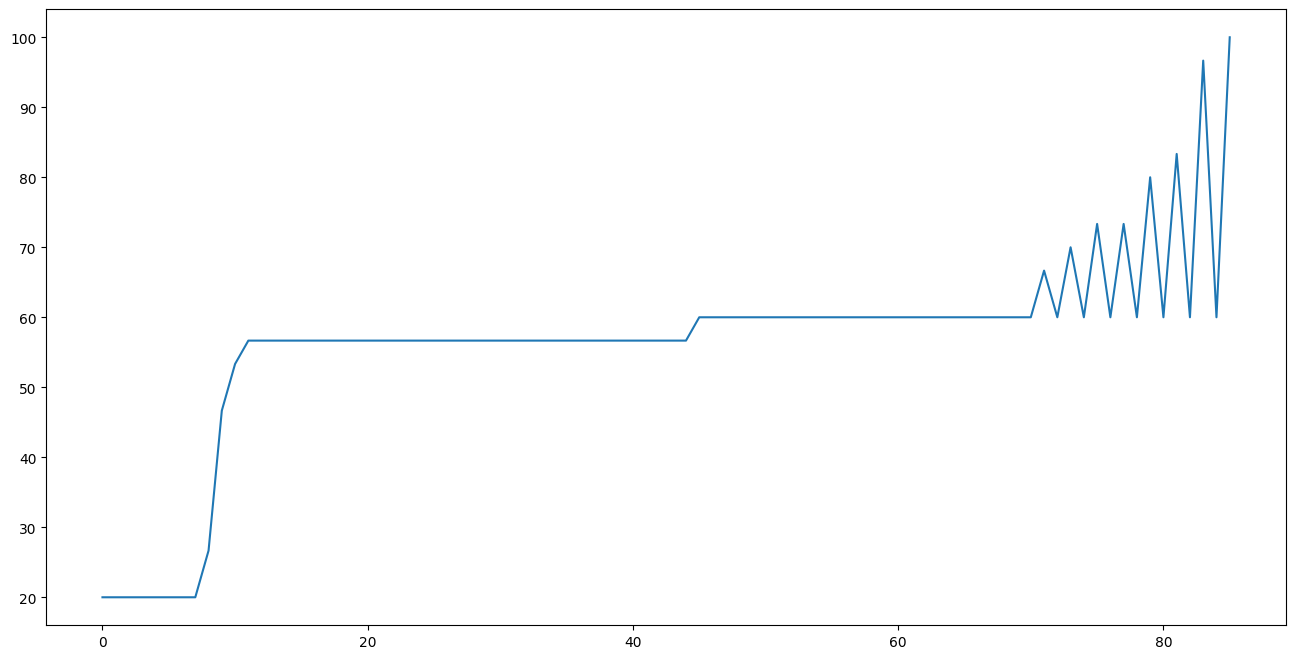

In [63]:
from sklearn.datasets import load_iris

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
    print("Running on CUDA.")
else:
    my_device = torch.device("cpu")
    print("No Cuda Available")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-1
prefix = 'ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris

net = train( dataset=dataset, epochs=epochs, device=my_device, 
            upper_bound=99.9, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=False, prefix=prefix
           )
#Era a versão do numpy que deu problema que te perguntei em sala, abaixei para a versão 1.20.0 e foi

Running on CUDA.


Training epochs...:   1%|█▎                                                                                                                                                                                                                       | 3/500 [00:00<00:19, 25.58it/s]

Saving the best model at epoch   1 with Accuracy:  20.0000%
Saving the best model at epoch   3 with Accuracy:  56.6667%
Saving the best model at epoch   4 with Accuracy:  60.0000%


Training epochs...:   3%|█████▌                                                                                                                                                                                                                  | 13/500 [00:00<00:17, 27.54it/s]

Saving the best model at epoch   9 with Accuracy:  76.6667%
Saving the best model at epoch  10 with Accuracy:  86.6667%
Saving the best model at epoch  11 with Accuracy:  96.6667%
Saving the best model at epoch  14 with Accuracy: 100.0000%


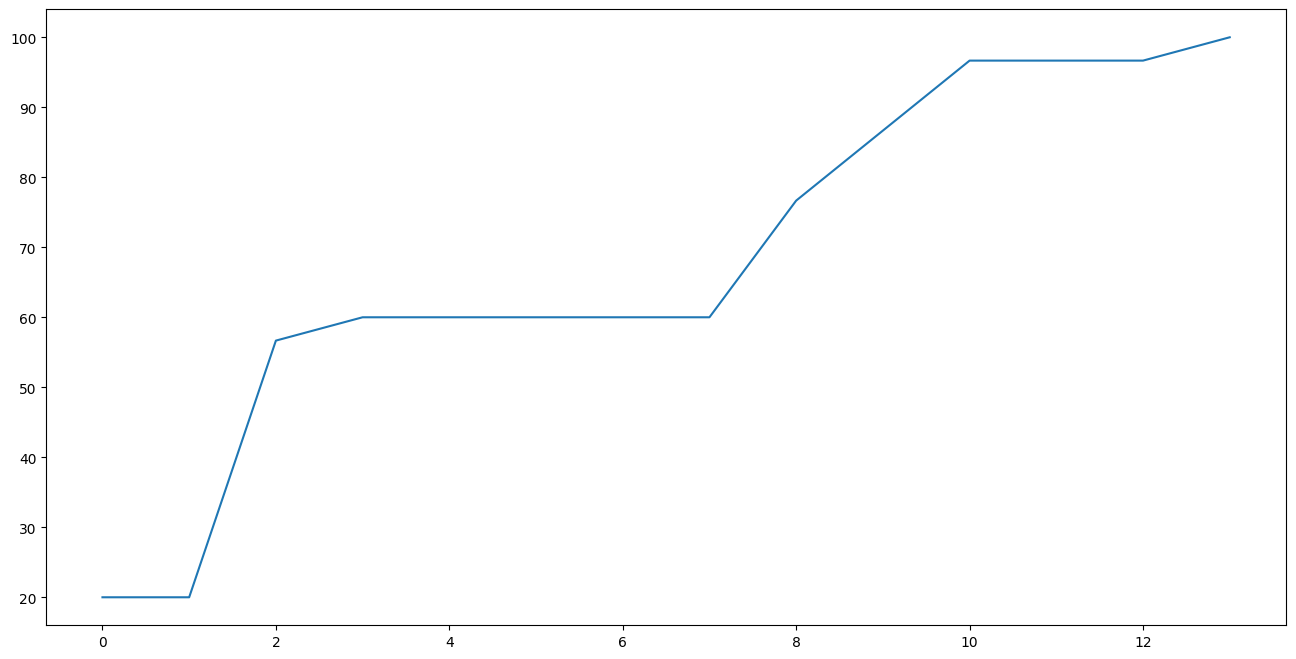

In [64]:
from sklearn.datasets import load_iris

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
    print("Running on CUDA.")
else:
    my_device = torch.device("cpu")
    print("No Cuda Available")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-1
prefix = 'ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris


net = train_batch( dataset=dataset, epochs=epochs, device=my_device, 
                upper_bound=99.9, lr=lr, lambda_reg=lambda_reg,
                layers2tensorboard=True, save=False, prefix=prefix, batch_size = 30
               )


## Conclusion
In conclusion, we achieved 100% accuracy in both batch size learning and all-at-once training methods. However, with a batch size of 30, we achieved this accuracy faster, reaching it in epoch 14, compared to epoch 86 in the all-at-once method. This demonstrates the efficiency of using batch size learning in training models.

In [13]:
import numpy
print(numpy.__version__)
print(torch.__version__)

1.20.0
1.12.1+cu113
